In [3]:
!python -V

Python 3.10.14


In [4]:
import pandas as pd

In [5]:
import pickle

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [27]:
import mlflow

mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc-taxi-experiment')

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716693663800, experiment_id='1', last_update_time=1716693663800, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [28]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [29]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829626

/tmp/ipykernel_5651/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_5651/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


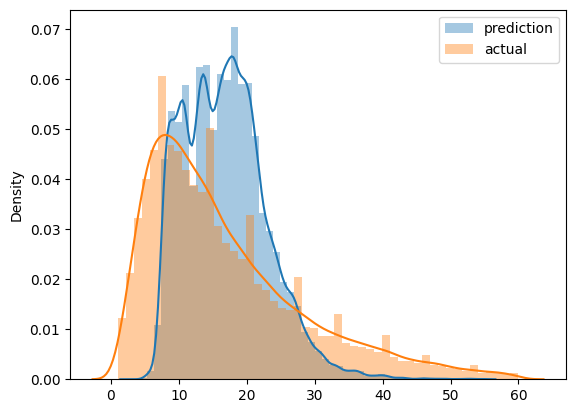

In [11]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [12]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [13]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [14]:
len(df_train), len(df_val)

(73908, 61921)

In [15]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [16]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [17]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715208009878

In [21]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [22]:
#using mlflow to log experiments and relevant parameters
with mlflow.start_run():
    mlflow.set_tag("developer", "pj")
    
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(0.01)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [19]:
import xgboost as xgb

In [20]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [21]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [26]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [27]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                                                                                                      | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:35:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.29517                                                                                                                                      
[1]	validation-rmse:9.00849                                                                                                                                       
[2]	validation-rmse:8.14780                                                                                                                                       
[3]	validation-rmse:7.58468                                                                                                                                       
[4]	validation-rmse:7.23249                                                                                                                                       
[5]	validation-rmse:7.01043                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:38:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.71267                                                                                                                                      
[1]	validation-rmse:9.58272                                                                                                                                       
[2]	validation-rmse:8.74190                                                                                                                                       
[3]	validation-rmse:8.12953                                                                                                                                       
[4]	validation-rmse:7.68286                                                                                                                                       
[5]	validation-rmse:7.36442                                                                                                                                       
[6]	validation-rmse:7.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:40:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.22678                                                                                                                                      
[1]	validation-rmse:10.40135                                                                                                                                      
[2]	validation-rmse:9.71373                                                                                                                                       
[3]	validation-rmse:9.14516                                                                                                                                       
[4]	validation-rmse:8.67787                                                                                                                                       
[5]	validation-rmse:8.29628                                                                                                                                       
[6]	validation-rmse:7.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:42:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.67795                                                                                                                                      
[1]	validation-rmse:11.18958                                                                                                                                      
[2]	validation-rmse:10.74488                                                                                                                                      
[3]	validation-rmse:10.34085                                                                                                                                      
[4]	validation-rmse:9.97401                                                                                                                                       
[5]	validation-rmse:9.64174                                                                                                                                       
[6]	validation-rmse:9.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:45:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.74221                                                                                                                                      
[1]	validation-rmse:11.30758                                                                                                                                      
[2]	validation-rmse:10.90751                                                                                                                                      
[3]	validation-rmse:10.53889                                                                                                                                      
[4]	validation-rmse:10.20147                                                                                                                                      
[5]	validation-rmse:9.89138                                                                                                                                       
[6]	validation-rmse:9.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:46:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.47644                                                                                                                                      
[1]	validation-rmse:9.24727                                                                                                                                       
[2]	validation-rmse:8.39825                                                                                                                                       
[3]	validation-rmse:7.82343                                                                                                                                       
[4]	validation-rmse:7.42251                                                                                                                                       
[5]	validation-rmse:7.15773                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:48:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.87347                                                                                                                                      
[1]	validation-rmse:9.83832                                                                                                                                       
[2]	validation-rmse:9.03613                                                                                                                                       
[3]	validation-rmse:8.42152                                                                                                                                       
[4]	validation-rmse:7.96158                                                                                                                                       
[5]	validation-rmse:7.61635                                                                                                                                       
[6]	validation-rmse:7.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:52:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.01219                                                                                                                                       
[1]	validation-rmse:7.58982                                                                                                                                       
[2]	validation-rmse:7.00067                                                                                                                                       
[3]	validation-rmse:6.75770                                                                                                                                       
[4]	validation-rmse:6.64305                                                                                                                                       
[5]	validation-rmse:6.58713                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:53:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.48001                                                                                                                                       
[1]	validation-rmse:7.23435                                                                                                                                       
[2]	validation-rmse:6.82810                                                                                                                                       
[3]	validation-rmse:6.68339                                                                                                                                       
[4]	validation-rmse:6.61469                                                                                                                                       
[5]	validation-rmse:6.58931                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:54:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80900                                                                                                                                      
[1]	validation-rmse:11.43198                                                                                                                                      
[2]	validation-rmse:11.07936                                                                                                                                      
[3]	validation-rmse:10.75137                                                                                                                                      
[4]	validation-rmse:10.44544                                                                                                                                      
[5]	validation-rmse:10.16098                                                                                                                                      
[6]	validation-rmse:9.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:56:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.49989                                                                                                                                      
[1]	validation-rmse:10.87032                                                                                                                                      
[2]	validation-rmse:10.31547                                                                                                                                      
[3]	validation-rmse:9.83186                                                                                                                                       
[4]	validation-rmse:9.40111                                                                                                                                       
[5]	validation-rmse:9.03122                                                                                                                                       
[6]	validation-rmse:8.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:03:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.54230                                                                                                                                      
[1]	validation-rmse:10.94354                                                                                                                                      
[2]	validation-rmse:10.41060                                                                                                                                      
[3]	validation-rmse:9.93740                                                                                                                                       
[4]	validation-rmse:9.51846                                                                                                                                       
[5]	validation-rmse:9.14839                                                                                                                                       
[6]	validation-rmse:8.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:09:30] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.03210                                                                                                                                       
[1]	validation-rmse:6.94561                                                                                                                                       
[2]	validation-rmse:6.67871                                                                                                                                       
[3]	validation-rmse:6.59586                                                                                                                                       
[4]	validation-rmse:6.56294                                                                                                                                       
[5]	validation-rmse:6.54533                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:10:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.15800                                                                                                                                       
[1]	validation-rmse:7.07793                                                                                                                                       
[2]	validation-rmse:6.79672                                                                                                                                       
[3]	validation-rmse:6.71029                                                                                                                                       
[4]	validation-rmse:6.67907                                                                                                                                       
[5]	validation-rmse:6.66150                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:11:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.99261                                                                                                                                       
[1]	validation-rmse:6.60628                                                                                                                                       
[2]	validation-rmse:6.56409                                                                                                                                       
[3]	validation-rmse:6.56155                                                                                                                                       
[4]	validation-rmse:6.54762                                                                                                                                       
[5]	validation-rmse:6.53668                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:11:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.02892                                                                                                                                       
[1]	validation-rmse:7.65206                                                                                                                                       
[2]	validation-rmse:7.08891                                                                                                                                       
[3]	validation-rmse:6.85487                                                                                                                                       
[4]	validation-rmse:6.75720                                                                                                                                       
[5]	validation-rmse:6.71172                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:12:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.40295                                                                                                                                      
[1]	validation-rmse:10.70063                                                                                                                                      
[2]	validation-rmse:10.09299                                                                                                                                      
[3]	validation-rmse:9.56808                                                                                                                                       
[4]	validation-rmse:9.11750                                                                                                                                       
[5]	validation-rmse:8.73483                                                                                                                                       
[6]	validation-rmse:8.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:18:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.34263                                                                                                                                       
[1]	validation-rmse:6.83102                                                                                                                                       
[2]	validation-rmse:6.75302                                                                                                                                       
[3]	validation-rmse:6.72502                                                                                                                                       
[4]	validation-rmse:6.71500                                                                                                                                       
[5]	validation-rmse:6.71104                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:19:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.50393                                                                                                                                       
[1]	validation-rmse:7.22978                                                                                                                                       
[2]	validation-rmse:6.82165                                                                                                                                       
[3]	validation-rmse:6.67433                                                                                                                                       
[4]	validation-rmse:6.61302                                                                                                                                       
[5]	validation-rmse:6.58237                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:20:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.43651                                                                                                                                      
[1]	validation-rmse:10.75973                                                                                                                                      
[2]	validation-rmse:10.17264                                                                                                                                      
[3]	validation-rmse:9.66529                                                                                                                                       
[4]	validation-rmse:9.22857                                                                                                                                       
[5]	validation-rmse:8.85400                                                                                                                                       
[6]	validation-rmse:8.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:23:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.29657                                                                                                                                      
[1]	validation-rmse:8.99547                                                                                                                                       
[2]	validation-rmse:8.13035                                                                                                                                       
[3]	validation-rmse:7.57253                                                                                                                                       
[4]	validation-rmse:7.21185                                                                                                                                       
[5]	validation-rmse:6.98231                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:25:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.95370                                                                                                                                       
[1]	validation-rmse:8.56340                                                                                                                                       
[2]	validation-rmse:7.73271                                                                                                                                       
[3]	validation-rmse:7.25366                                                                                                                                       
[4]	validation-rmse:6.97566                                                                                                                                       
[5]	validation-rmse:6.81227                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:26:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.95236                                                                                                                                      
[1]	validation-rmse:9.94965                                                                                                                                       
[2]	validation-rmse:9.16127                                                                                                                                       
[3]	validation-rmse:8.54418                                                                                                                                       
[4]	validation-rmse:8.06934                                                                                                                                       
[5]	validation-rmse:7.70616                                                                                                                                       
[6]	validation-rmse:7.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:29:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.71965                                                                                                                                       
[1]	validation-rmse:8.26956                                                                                                                                       
[2]	validation-rmse:7.46238                                                                                                                                       
[3]	validation-rmse:7.02853                                                                                                                                       
[4]	validation-rmse:6.79383                                                                                                                                       
[5]	validation-rmse:6.66057                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:30:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.71591                                                                                                                                      
[1]	validation-rmse:9.58809                                                                                                                                       
[2]	validation-rmse:8.75229                                                                                                                                       
[3]	validation-rmse:8.13852                                                                                                                                       
[4]	validation-rmse:7.69564                                                                                                                                       
[5]	validation-rmse:7.37978                                                                                                                                       
[6]	validation-rmse:7.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:33:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.14158                                                                                                                                      
[1]	validation-rmse:10.25943                                                                                                                                      
[2]	validation-rmse:9.53926                                                                                                                                       
[3]	validation-rmse:8.95459                                                                                                                                       
[4]	validation-rmse:8.48302                                                                                                                                       
[5]	validation-rmse:8.10666                                                                                                                                       
[6]	validation-rmse:7.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:37:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.60948                                                                                                                                       
[1]	validation-rmse:8.15650                                                                                                                                       
[2]	validation-rmse:7.38883                                                                                                                                       
[3]	validation-rmse:6.98819                                                                                                                                       
[4]	validation-rmse:6.77539                                                                                                                                       
[5]	validation-rmse:6.66315                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:38:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.68771                                                                                                                                       
[1]	validation-rmse:8.26380                                                                                                                                       
[2]	validation-rmse:7.50255                                                                                                                                       
[3]	validation-rmse:7.10201                                                                                                                                       
[4]	validation-rmse:6.88243                                                                                                                                       
[5]	validation-rmse:6.76274                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:39:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.50142                                                                                                                                      
[1]	validation-rmse:9.28571                                                                                                                                       
[2]	validation-rmse:8.43321                                                                                                                                       
[3]	validation-rmse:7.84649                                                                                                                                       
[4]	validation-rmse:7.43977                                                                                                                                       
[5]	validation-rmse:7.17548                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:42:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.34385                                                                                                                                       
[1]	validation-rmse:7.88285                                                                                                                                       
[2]	validation-rmse:7.18791                                                                                                                                       
[3]	validation-rmse:6.85922                                                                                                                                       
[4]	validation-rmse:6.69375                                                                                                                                       
[5]	validation-rmse:6.60870                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:43:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.63617                                                                                                                                       
[1]	validation-rmse:6.62531                                                                                                                                       
[2]	validation-rmse:6.61318                                                                                                                                       
[3]	validation-rmse:6.60368                                                                                                                                       
[4]	validation-rmse:6.59497                                                                                                                                       
[5]	validation-rmse:6.58407                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:44:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.16736                                                                                                                                       
[1]	validation-rmse:7.74874                                                                                                                                       
[2]	validation-rmse:7.13023                                                                                                                                       
[3]	validation-rmse:6.86421                                                                                                                                       
[4]	validation-rmse:6.72996                                                                                                                                       
[5]	validation-rmse:6.66227                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:45:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.95902                                                                                                                                       
[1]	validation-rmse:8.54583                                                                                                                                       
[2]	validation-rmse:7.68792                                                                                                                                       
[3]	validation-rmse:7.18489                                                                                                                                       
[4]	validation-rmse:6.89113                                                                                                                                       
[5]	validation-rmse:6.72212                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:46:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.45752                                                                                                                                       
[1]	validation-rmse:6.82076                                                                                                                                       
[2]	validation-rmse:6.72232                                                                                                                                       
[3]	validation-rmse:6.69399                                                                                                                                       
[4]	validation-rmse:6.68128                                                                                                                                       
[5]	validation-rmse:6.67456                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:47:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.52056                                                                                                                                       
[1]	validation-rmse:8.10016                                                                                                                                       
[2]	validation-rmse:7.39530                                                                                                                                       
[3]	validation-rmse:7.04498                                                                                                                                       
[4]	validation-rmse:6.87005                                                                                                                                       
[5]	validation-rmse:6.77711                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:49:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.91131                                                                                                                                       
[1]	validation-rmse:6.76044                                                                                                                                       
[2]	validation-rmse:6.74543                                                                                                                                       
[3]	validation-rmse:6.74191                                                                                                                                       
[4]	validation-rmse:6.73068                                                                                                                                       
[5]	validation-rmse:6.72215                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:49:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.81764                                                                                                                                       
[1]	validation-rmse:6.99304                                                                                                                                       
[2]	validation-rmse:6.83403                                                                                                                                       
[3]	validation-rmse:6.79440                                                                                                                                       
[4]	validation-rmse:6.78778                                                                                                                                       
[5]	validation-rmse:6.77976                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:50:48] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.32427                                                                                                                                      
[1]	validation-rmse:9.04368                                                                                                                                       
[2]	validation-rmse:8.20319                                                                                                                                       
[3]	validation-rmse:7.65254                                                                                                                                       
[4]	validation-rmse:7.30444                                                                                                                                       
[5]	validation-rmse:7.08236                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:52:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.42681                                                                                                                                       
[1]	validation-rmse:7.98597                                                                                                                                       
[2]	validation-rmse:7.28447                                                                                                                                       
[3]	validation-rmse:6.94779                                                                                                                                       
[4]	validation-rmse:6.78112                                                                                                                                       
[5]	validation-rmse:6.69528                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:54:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.68195                                                                                                                                      
[1]	validation-rmse:9.54336                                                                                                                                       
[2]	validation-rmse:8.71023                                                                                                                                       
[3]	validation-rmse:8.10088                                                                                                                                       
[4]	validation-rmse:7.65831                                                                                                                                       
[5]	validation-rmse:7.35116                                                                                                                                       
[6]	validation-rmse:7.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:57:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.97775                                                                                                                                      
[1]	validation-rmse:10.00158                                                                                                                                      
[2]	validation-rmse:9.24064                                                                                                                                       
[3]	validation-rmse:8.65209                                                                                                                                       
[4]	validation-rmse:8.20202                                                                                                                                       
[5]	validation-rmse:7.86083                                                                                                                                       
[6]	validation-rmse:7.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:58:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.69443                                                                                                                                       
[1]	validation-rmse:7.37177                                                                                                                                       
[2]	validation-rmse:6.90700                                                                                                                                       
[3]	validation-rmse:6.72222                                                                                                                                       
[4]	validation-rmse:6.64807                                                                                                                                       
[5]	validation-rmse:6.61235                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:59:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.05146                                                                                                                                      
[1]	validation-rmse:8.66212                                                                                                                                       
[2]	validation-rmse:7.79669                                                                                                                                       
[3]	validation-rmse:7.27542                                                                                                                                       
[4]	validation-rmse:6.96388                                                                                                                                       
[5]	validation-rmse:6.77664                                                                                                                                       
[6]	validation-rmse:6.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:01:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.14824                                                                                                                                      
[1]	validation-rmse:10.26875                                                                                                                                      
[2]	validation-rmse:9.54514                                                                                                                                       
[3]	validation-rmse:8.95612                                                                                                                                       
[4]	validation-rmse:8.47848                                                                                                                                       
[5]	validation-rmse:8.09444                                                                                                                                       
[6]	validation-rmse:7.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:05:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.23746                                                                                                                                      
[1]	validation-rmse:10.41511                                                                                                                                      
[2]	validation-rmse:9.72797                                                                                                                                       
[3]	validation-rmse:9.15593                                                                                                                                       
[4]	validation-rmse:8.68180                                                                                                                                       
[5]	validation-rmse:8.29151                                                                                                                                       
[6]	validation-rmse:7.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:08:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69664                                                                                                                                      
[1]	validation-rmse:11.22313                                                                                                                                      
[2]	validation-rmse:10.79050                                                                                                                                      
[3]	validation-rmse:10.39460                                                                                                                                      
[4]	validation-rmse:10.03330                                                                                                                                      
[5]	validation-rmse:9.70350                                                                                                                                       
[6]	validation-rmse:9.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:10:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.78188                                                                                                                                      
[1]	validation-rmse:11.37980                                                                                                                                      
[2]	validation-rmse:11.00618                                                                                                                                      
[3]	validation-rmse:10.65937                                                                                                                                      
[4]	validation-rmse:10.33732                                                                                                                                      
[5]	validation-rmse:10.03910                                                                                                                                      
[6]	validation-rmse:9.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:13:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.58787                                                                                                                                      
[1]	validation-rmse:11.02657                                                                                                                                      
[2]	validation-rmse:10.52389                                                                                                                                      
[3]	validation-rmse:10.07497                                                                                                                                      
[4]	validation-rmse:9.67464                                                                                                                                       
[5]	validation-rmse:9.31890                                                                                                                                       
[6]	validation-rmse:9.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:15:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.20564                                                                                                                                      
[1]	validation-rmse:10.36704                                                                                                                                      
[2]	validation-rmse:9.67504                                                                                                                                       
[3]	validation-rmse:9.10709                                                                                                                                       
[4]	validation-rmse:8.64256                                                                                                                                       
[5]	validation-rmse:8.26841                                                                                                                                       
[6]	validation-rmse:7.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:17:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.37964                                                                                                                                      
[1]	validation-rmse:10.66097                                                                                                                                      
[2]	validation-rmse:10.04365                                                                                                                                      
[3]	validation-rmse:9.50863                                                                                                                                       
[4]	validation-rmse:9.05993                                                                                                                                       
[5]	validation-rmse:8.67743                                                                                                                                       
[6]	validation-rmse:8.

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [28]:
params = {
'learning_rate': 0.1333622219357932,
'max_depth': 34,
'min_child_weight': 1.5780403064529516,
'objective': 'reg:linear',
'reg_alpha': 0.1826318770699728,
'reg_lambda': 0.020596792215425788,
'seed': 42
}

#mlflow allows some model types like sklearn, pytorch etc autolog where the model and other details of the model are auto logged.
mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2024/05/26 19:00:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8dd154d760e74829a8a96393e6f2140e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:00:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.14824
[1]	validation-rmse:10.26875
[2]	validation-rmse:9.54514
[3]	validation-rmse:8.95612
[4]	validation-rmse:8.47848
[5]	validation-rmse:8.09444
[6]	validation-rmse:7.78773
[7]	validation-rmse:7.54107
[8]	validation-rmse:7.34570
[9]	validation-rmse:7.18855
[10]	validation-rmse:7.06431
[11]	validation-rmse:6.96217
[12]	validation-rmse:6.88248
[13]	validation-rmse:6.81879
[14]	validation-rmse:6.76660
[15]	validation-rmse:6.72339
[16]	validation-rmse:6.68786
[17]	validation-rmse:6.65868
[18]	validation-rmse:6.63532
[19]	validation-rmse:6.61413
[20]	validation-rmse:6.59684
[21]	validation-rmse:6.58239
[22]	validation-rmse:6.57075
[23]	validation-rmse:6.56051
[24]	validation-rmse:6.55146
[25]	validation-rmse:6.54294
[26]	validation-rmse:6.53608
[27]	validation-rmse:6.53072
[28]	validation-rmse:6.52441
[29]	validation-rmse:6.51933
[30]	validation-rmse:6.51487
[31]	validation-rmse:6.51215
[32]	validation-rmse:6.51013
[33]	validation-rmse:6.50795
[34]	validation-rmse:6

2024/05/26 19:04:33 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/26 19:04:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:04:33] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


In [34]:
#model management
best_params = {
'learning_rate': 0.1333622219357932,
'max_depth': 34,
'min_child_weight': 1.5780403064529516,
'objective': 'reg:linear',
'reg_alpha': 0.1826318770699728,
'reg_lambda': 0.020596792215425788,
'seed': 42
}

mlflow.log_params(best_params)

booster = xgb.train(
            params=best_params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

y_pred = booster.predict(valid)
rmse = mean_squared_error(y_val, y_pred, squared=False)
mlflow.log_metric("rmse", rmse)

#store dv since we need it for preprocessing to replicate model results
with open('models/preprocessor.b', 'wb') as f_out:
    pickle.dump(dv, f_out)

mlflow.log_artifact('models/preprocessor.b', artifact_path='preprocessor')

mlflow.xgboost.log_model(booster, artifact_path='model_mlflow')

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:11:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.14824
[1]	validation-rmse:10.26875
[2]	validation-rmse:9.54514
[3]	validation-rmse:8.95612
[4]	validation-rmse:8.47848
[5]	validation-rmse:8.09444
[6]	validation-rmse:7.78773
[7]	validation-rmse:7.54107
[8]	validation-rmse:7.34570
[9]	validation-rmse:7.18855
[10]	validation-rmse:7.06431
[11]	validation-rmse:6.96217
[12]	validation-rmse:6.88248
[13]	validation-rmse:6.81879
[14]	validation-rmse:6.76660
[15]	validation-rmse:6.72339
[16]	validation-rmse:6.68786
[17]	validation-rmse:6.65868
[18]	validation-rmse:6.63532
[19]	validation-rmse:6.61413
[20]	validation-rmse:6.59684
[21]	validation-rmse:6.58239
[22]	validation-rmse:6.57075
[23]	validation-rmse:6.56051
[24]	validation-rmse:6.55146
[25]	validation-rmse:6.54294
[26]	validation-rmse:6.53608
[27]	validation-rmse:6.53072
[28]	validation-rmse:6.52441
[29]	validation-rmse:6.51933
[30]	validation-rmse:6.51487
[31]	validation-rmse:6.51215
[32]	validation-rmse:6.51013
[33]	validation-rmse:6.50795
[34]	validation-rmse:6

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:14:44] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is i

In [35]:
#copied from mlflow Artifacts to predict(python flavor)
import mlflow
logged_model = 'runs:/8cac3d96d0ab4c6da8f4eaf3f1f31b55/model_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:17:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [36]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: model_mlflow
  flavor: mlflow.xgboost
  run_id: 8cac3d96d0ab4c6da8f4eaf3f1f31b55

In [39]:
#xgboost flavor
xgboost_model = mlflow.xgboost.load_model(logged_model)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:18:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [40]:
xgboost_model

In [41]:
y_pred = xgboost_model.predict(valid)

In [42]:
y_pred

array([14.462912,  7.205084, 15.403749, ..., 13.5056  ,  6.264423,
        8.114546], dtype=float32)

In [5]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [6]:
#redo data fetch and preprocessing
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

#train and val has about 70k rows. The notebook crashes while trianing. So limiting to 5k rows
df_train = df_train.sample(5000)
df_val = df_val.sample(5000)


df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [ ]:
#create multiple models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR
import mlflow

mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc-taxi-experiment')

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

In [7]:
#redo data fetch and preprocessing
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

#train and val has about 70k rows. The notebook crashes while trianing. So limiting to 5k rows
#df_train = df_train.sample(5000)
#df_val = df_val.sample(5000)


df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [ ]:
#create multiple models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR
import mlflow

#if we don't set uri, mlflow will look locally.
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc-taxi-experiment')

mlflow.sklearn.autolog()



with mlflow.start_run():
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlmodel = ExtraTreesRegressor()
    mlmodel.fit(X_train, y_train)

    y_pred = mlmodel.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

2024/05/27 05:46:01 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'


In [8]:
X_train

<73908x13221 sparse matrix of type '<class 'numpy.float64'>'
	with 147816 stored elements in Compressed Sparse Row format>